In [ ]:
# MIT License

# Copyright (c) 2023 Constantine Giantselidis

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [6]:
#Import the required dependencies
import tensorflow as tf
import numpy as np
import cv2
import imghdr
import os
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import Precision, Recall, BinaryAccuracy

In [7]:
data_dir = 'data'
image_extensions = ['jpg', 'jpeg', 'png']

# loop through all our data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # check if the extension fits out list of allowed extensions
            tip = imghdr.what(image_path)
            # if not remove that image
            if tip not in image_extensions:
                print('image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('issue with image {}'.format(image_path))
            os.remove(image_path)

In [8]:
# build a dataset on the fly using tf.keras which will automatically create a dataset from our images + resize
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=4)

Found 10605 files belonging to 2 classes.


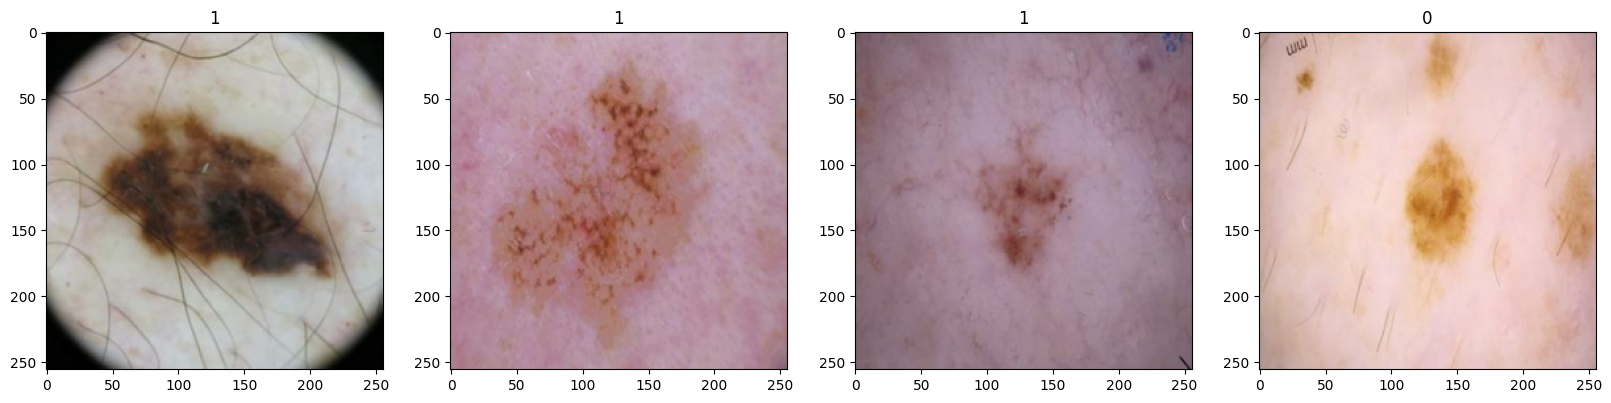

In [9]:
# convert it to a numpy iterator (allows us to access our data pipeline since the data is not preloaded in the memory, it is a generator)
data_iterator = data.as_numpy_iterator()

# get a batch from the iterator
batch = data_iterator.next()

# visualize a batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int), vmin=0, vmax=1)
    ax[idx].title.set_text(batch[1][idx])

In [10]:
# scale data using map function
def preprocess_data(x, y):
    x = x/255
    return x, y
data = data.map(preprocess_data)

# convert it to a numpy iterator (allows us to access our data pipeline)
scaled_iterator = data.as_numpy_iterator()

# get a batch from the iterator (allows us to access our data pipeline itself)
batch = scaled_iterator.next()

In [14]:
# split the data
train_size = int(len(data)*.2)
validation_size = int(len(data)*.3)
test_size = int(len(data)*.1)+1

# use take and skip methods (how many batches we want to allocate for each split we declared)
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test_size = data.skip(train_size+validation_size).take(test_size)

In [15]:
# create the model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import Precision, Recall, BinaryAccuracy

# declare our model using the Sequential api
model = Sequential()
# add layers to the model

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

# similarly add a convolution with 32 filters this time and relu activation
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# similarly add a convolution with 16 filters again this time and relu activation
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# flatten the data down
model.add(Flatten())

# add fully connected Dense layers with 256 neurons and relu activation
model.add(Dense(256, activation='relu'))
# add a final Dense layer with 1 neuron to get a single output that is going to represent 0 or 1 with a sigmoid activation (which will match our classes)
model.add(Dense(1, activation='sigmoid'))

# compile our model with adam optimizer and define what our losses are and an accuracy metric
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [16]:
logdir = 'data/logs'
# used for logging out the model training as its training, so we can come back and see how it performed at a particular time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# fit the model
hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/30
530/530 [==============================] - 86s 160ms/step - loss: 0.6066 - accuracy: 0.6717 - val_loss: 0.5348 - val_accuracy: 0.7242
Epoch 2/30
530/530 [==============================] - 83s 156ms/step - loss: 0.5561 - accuracy: 0.7061 - val_loss: 0.4991 - val_accuracy: 0.7616
Epoch 3/30
530/530 [==============================] - 84s 159ms/step - loss: 0.5412 - accuracy: 0.7038 - val_loss: 0.5455 - val_accuracy: 0.7164
Epoch 4/30
530/530 [==============================] - 83s 157ms/step - loss: 0.4781 - accuracy: 0.7675 - val_loss: 0.3990 - val_accuracy: 0.8274
Epoch 5/30
530/530 [==============================] - 84s 158ms/step - loss: 0.3836 - accuracy: 0.8297 - val_loss: 0.4071 - val_accuracy: 0.8242
Epoch 6/30
530/530 [==============================] - 85s 160ms/step - loss: 0.3667 - accuracy: 0.8406 - val_loss: 0.4277 - val_accuracy: 0.8119
Epoch 7/30
530/530 [==============================] - 83s 157ms/step - loss: 0.3072 - accuracy: 0.8731 - val_loss: 0.3702 - val_ac

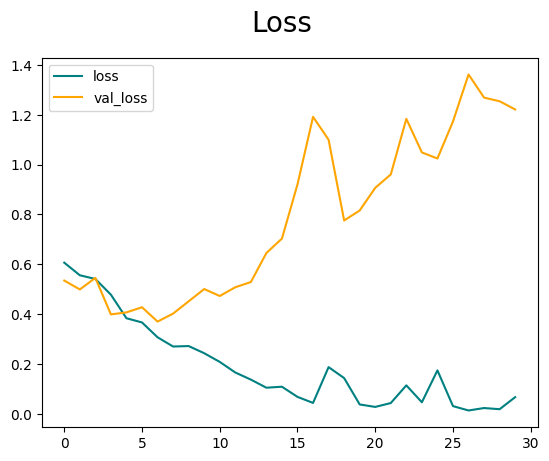

In [17]:
# Plot our model performance using matplotlib
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

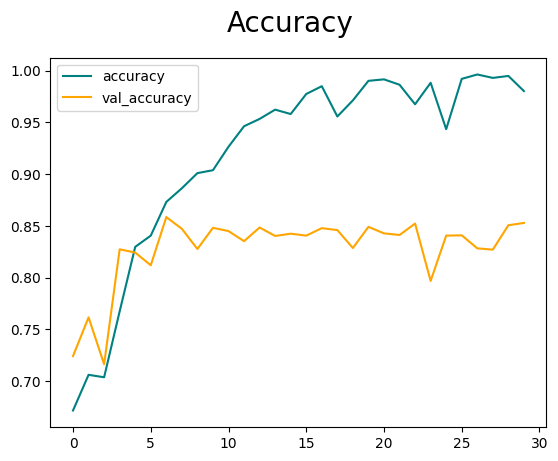

In [18]:
# Plot our model accuracy using matplotlib
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [19]:
# define some instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# loop through each batch in our test data and make a prediction
for batch in test_size.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 46ms/step
Precision:0.8301158547401428, Recall:0.8722109794616699, Accuracy:0.8580827116966248


In [20]:
# Save the model
model.save(os.path.join('data/models', 'malanoma_predictor1.h5'))

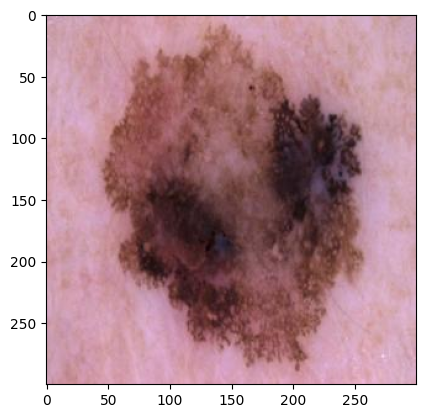

In [26]:
img = cv2.imread('data/melanoma_5020_mal.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

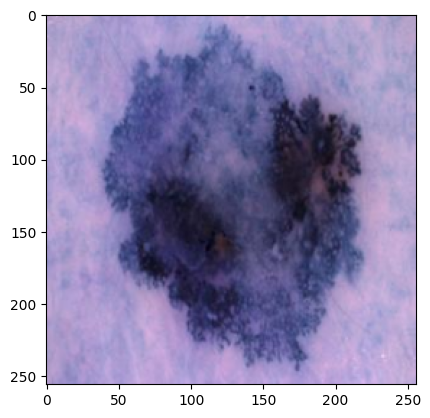

In [27]:
# resize image before prediction
resized_img = tf.image.resize(img, (256, 256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [28]:
result = model.predict(np.expand_dims(resized_img/255, 0))
print(result)
if result > 0.5:
    print(f'Predicted class is malignant')
else:
    print(f'Predicted class is benign')

1/1 [==============================] - 0s 30ms/step
[[1.]]
Predicted class is malignant
